In [24]:
%%capture
%pip install datasets[audio]==1.16.1 umap-learn==0.5.1 datasets[s3] transformers[tf,torch,sentencepiece,vision,optuna,sklearn,onnxruntime]==4.11.3

In [25]:
#hide
from utils import *
setup_chapter()

# Text Classification

## The Dataset

### A First Look at Hugging Face Datasets

In [26]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 32213 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [28]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [30]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [31]:
len(train_ds)

16000

In [32]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [33]:
train_ds.column_names

['text', 'label']

In [34]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [35]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [36]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### From Datasets to DataFrames

In [37]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [38]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

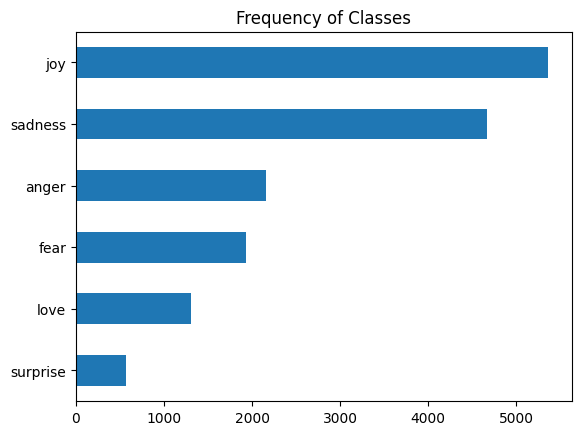

In [39]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### How Long Are Our Tweets?

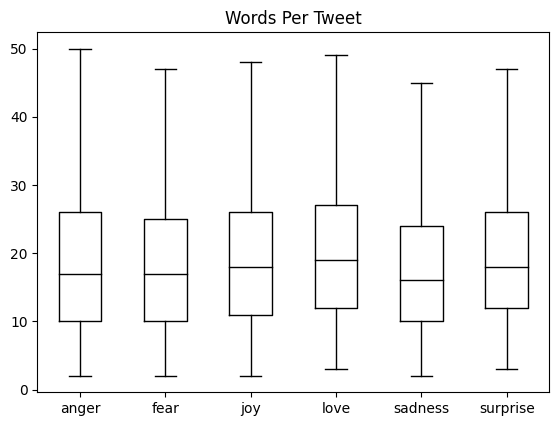

In [40]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [41]:
emotions.reset_format()

## From Text to Tokens

### Character Tokenization

In [42]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [43]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [44]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [45]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [46]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [47]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [48]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization

In [49]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### Subword Tokenization

In [50]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [52]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [53]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [54]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [55]:
tokenizer.vocab_size

30522

In [56]:
tokenizer.model_max_length

512

In [57]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the Whole Dataset

In [58]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [59]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [60]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [61]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [62]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

### Transformers as Feature Extractors

#### Using pretrained models

In [63]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Extracting the last hidden states

In [64]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [65]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [66]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [67]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [68]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [69]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [70]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [71]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### Creating a feature matrix

In [72]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set

In [73]:
!pip3 install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.302938,6.666787,0
1,-2.958236,6.122457,0
2,5.444973,3.095657,3
3,-2.169082,4.219548,2
4,-3.087656,4.186547,3


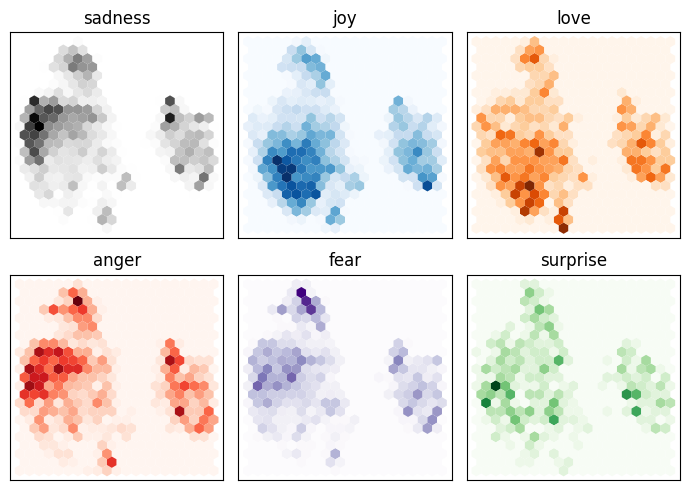

In [75]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### Training a simple classifier


In [76]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [77]:
lr_clf.score(X_valid, y_valid)

0.633

In [78]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

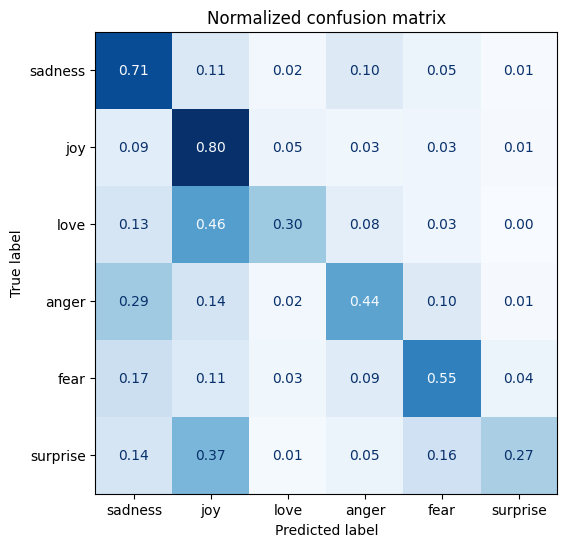

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

#### Loading a pretrained model

In [80]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

#### Defining the performance metrics

In [81]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

In [82]:
from huggingface_hub import notebook_login

notebook_login()

In [83]:
from huggingface_hub import HfFolder

username  = 'simonmesserli' #replace with your own username from hugging face.
hub_token = HfFolder.get_token()

### Training with SageMaker

In [85]:
!pip install sagemaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.0/748.0 kB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 9.7 MB/s eta 0:00:00
  Using cached boto3-1.26.124-py3-none-any.whl (135 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 27.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached botocore-1.29.124-py3-none-any.whl (10.7 MB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached s3transfer-0.6.0-py3-none-any.whl (79 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.1

In [86]:
import sagemaker.huggingface
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::123456789012:role/my-sagemaker-role
sagemaker bucket: my-sagemaker-bucket
sagemaker session region: us-west-2


In [87]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()

s3_prefix = 'samples/datasets/02_classification'

train_dataset=emotions_encoded["train"]
eval_dataset=emotions_encoded["validation"]

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path, fs=s3)

# save eval_dataset to s3
eval_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/validation'
eval_dataset.save_to_disk(eval_input_path, fs=s3)!pygmentize ./scripts/02_classification_train.py

In [87]:
from sagemaker.huggingface import HuggingFace
import time

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

# hyperparameters, which are passed into the training job
hyperparameters={'model_id':model_ckpt,
                 'num_train_epochs':2,
                 'learning_rate':2e-5,
                 'per_device_train_batch_size':batch_size,
                 'per_device_eval_batch_size':batch_size,
                 'learning_rate':2e-5,
                 'weight_decay':0.01,
                 'evaluation_strategy':"epoch",
                 'disable_tqdm':False,
                 'logging_steps':logging_steps,
                 'push_to_hub':True,
                 'hub_model_id':username + '/' + model_name,
                 'hub_strategy':"every_save",
                 'hub_token':hub_token
                }




In [87]:
# define Training Job Name 
job_name = f'nlp-book-sagemaker-02classificaton-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = '02_classification_train.py', # fine-tuning script used in training jon
    source_dir           = './scripts',                  # directory where fine-tuning script is stored
    instance_type        = 'ml.p3.2xlarge',              # instances type used for the training job
    instance_count       = 1,                            # the number of instances used for training
    base_job_name        = job_name,                     # the name of the training job
    role                 = role,                         # IAM role used in training job to access AWS ressources, e.g. Amazon S3
    transformers_version = '4.11',                       # the transformers version used in the training job
    pytorch_version      = '1.9',                        # the pytorch_version version used in the training job
    py_version           = 'py38',                       # the python version used in the training job
    hyperparameters      = hyperparameters,              # the hyperparameter used for running the training job
)

In [87]:
# define a data input dictonary with our uploaded s3 uris
data = {
    'train': training_input_path,
    'test': eval_input_path
}

# starting the train job with our uploaded datasets as input
huggingface_estimator.fit(data, wait=True)

The logs can be found in Amazon CloudWatch: https://console.aws.amazon.com/cloudwatch/home#logsV2:log-groups/log-group/$252Faws$252Fsagemaker$252FTrainingJobs

In [88]:
# the model is saved in the S3 bucket and was also pushed to the hugging face hub.
print(huggingface_estimator.model_data)

simonmesserli


In [88]:
from transformers import Trainer, AutoModel

# we load the model from the hub to the trainer and do further analyses.

model_finetuned = AutoModelForSequenceClassification.from_pretrained('simonmesserli' + '/' + model_name)

trainer = Trainer(model = model_finetuned)

### Deploy model with SageMaker Endpoint

In [88]:
predictor = huggingface_estimator.deploy(1,"ml.g4dn.xlarge")

In [88]:
custom_tweet = {"inputs" : "I saw a movie today and it was really good."}
predictor.predict(custom_tweet)

After running your requests, make sure to delete your endpoint.

In [88]:
predictor.delete_endpoint()

In [88]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

In [88]:
preds_output.metrics

In [88]:
y_preds = np.argmax(preds_output.predictions, axis=1)

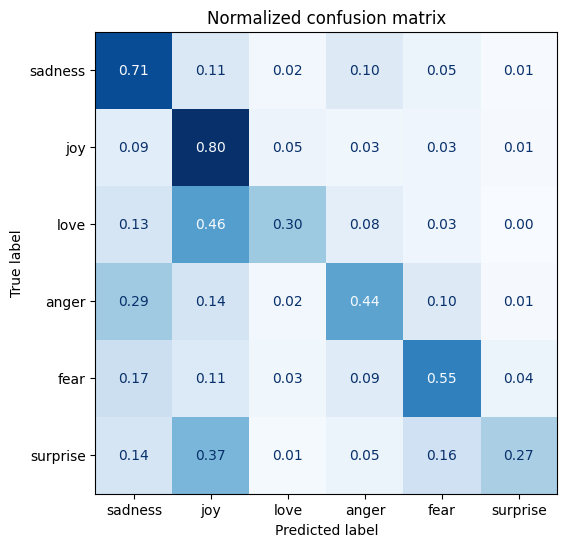

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### Error analysis

In [89]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [90]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [91]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [92]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1948,im just feeling so dazed everyday,surprise,love,1.909005
746,i feel they are amazing unique people and i lo...,surprise,love,1.903602
1453,im in the second trimester i feel amazing,surprise,love,1.899945
986,i am feeling amazing,surprise,love,1.896458
324,i saw him on galaxies magazine i feel curious ...,surprise,love,1.893868
1604,im not going to lie it feels really weird to b...,surprise,love,1.891647
583,i really did not feel so impressed with housto...,surprise,love,1.891142
457,im still feeling a little shocked over yesterd...,surprise,love,1.888494
227,i cant seem to get passed feeling stunned,surprise,love,1.887352
767,i have a feeling they might be pleasantly surp...,surprise,love,1.886536


In [96]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
136,i feel such gratitude for the generous gifts w...,love,love,1.657543
101,im feeling nostalgic cant beat the corys ifram...,love,love,1.658164
943,i understand now feel what my beloved meant wh...,love,love,1.661844
1543,im glad i feel this way because if i didnt the...,love,love,1.662635
909,i cant stop the joyful tears from flowing as i...,love,love,1.663890
145,i will never forget as he shot the dye into me...,love,love,1.664902
579,i feel loyal to a href http www,love,love,1.667458
60,i miss our talks our cuddling our kissing and ...,love,love,1.668127
1897,i hope that today you too may get into somethi...,love,love,1.669667
1341,i feel a longing to begin and to be there even...,love,love,1.669956


#### Saving and sharing the model

In [93]:
#hide_output
from transformers import pipeline

# Change `simonmesserli` to your Hub username
model_id = "simonmesserli/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [94]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


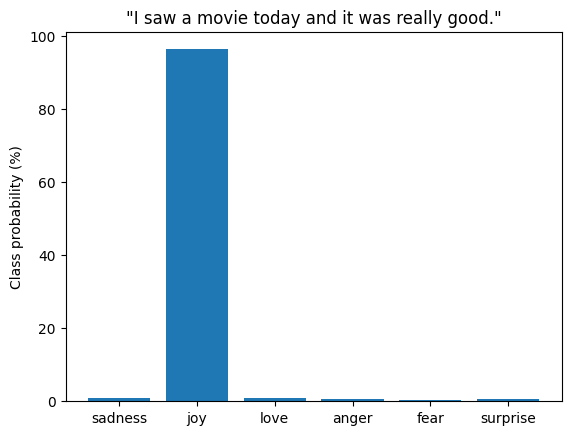

In [95]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion